Exemplo para Importar similaridades entre imagens, produtos.

Créditos: https://www.kaggle.com/code/jonathanoheix/product-recommendation-based-on-visual-similarity

Importar bibliotecas

In [1]:
from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

Definição dos parâmetros

In [9]:
#Criar pasta input/style e colocar o dataset dentro da pasta style

imgs_path = "/content/input/style/"
imgs_model_width, imgs_model_height = 224, 224

nb_closest_images = 5 # número de imagens pra recomendar

Carregar o modelo VGG

In [3]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
import os

# Diretório atual
current_directory = os.getcwd()
print("Diretório atual:", current_directory)

# Diretório pai (..)
parent_directory = os.path.dirname(current_directory)
print("Diretório pai (..):", parent_directory)

Diretório atual: /content
Diretório pai (..): /


In [6]:
!ls

input  sample_data


In [23]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "png" in x]

print("number of images:",len(files))

number of images: 17


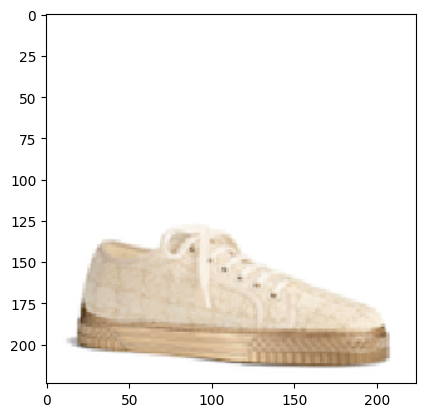

image loaded successfully!


In [24]:
# load an image in PIL format
original = load_img(files[0], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [25]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


In [26]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
features successfully extracted!
number of image features: 4096


array([[0.       , 0.       , 0.7341234, ..., 0.5175233, 0.       ,
        0.       ]], dtype=float32)

In [27]:
# load all the images and prepare them for feeding into the CNN

importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)

    importedImages.append(image_batch)

images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [28]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
features successfully extracted!


(17, 4096)

In [29]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

,/content/input/style/1_0_015.png,/content/input/style/2_5_009.png,/content/input/style/0_0_096.png,/content/input/style/1_5_020.png,/content/input/style/1_0_013.png,/content/input/style/1_0_014.png,/content/input/style/1_5_035.png,/content/input/style/2_5_007.png,/content/input/style/2_5_010.png,/content/input/style/0_0_003.png,/content/input/style/0_0_095.png,/content/input/style/1_5_027.png,/content/input/style/1_5_028.png,/content/input/style/2_5_008.png,/content/input/style/5_0_047.png,/content/input/style/5_0_051.png,/content/input/style/0_0_094.png
/content/input/style/1_0_015.png,1.000000,0.157138,0.621338,0.303344,0.562474,0.629904,0.339636,0.168721,0.108645,0.727372,0.586910,0.233763,0.317382,0.111796,0.438426,0.517545,0.604157
/content/input/style/2_5_009.png,0.157138,1.000000,0.095602,0.411918,0.104282,0.172799,0.437813,0.627325,0.674143,0.154389,0.161339,0.564315,0.354478,0.753176,0.114187,0.128913,0.159332
/content/input/style/0_0_096.png,0.621338,0.095602,1.000000,0.185794,0.641690,0.639460,0.194579,0.124224,0.079051,0.716811,0.629440,0.126406,0.247073,0.095275,0.659208,0.586342,0.710963
/content/input/style/1_5_020.png,0.303344,0.411918,0.185794,1.000000,0.247112,0.327745,0.705812,0.491392,0.523456,0.324013,0.316080,0.427900,0.517197,0.509963,0.180198,0.224176,0.274679
/content/input/style/1_0_013.png,0.562474,0.104282,0.641690,0.247112,1.000000,0.696517,0.189852,0.122851,0.098683,0.657076,0.723120,0.152033,0.237527,0.106269,0.527889,0.560206,0.684689


In [30]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

-----------------------------------------------------------------------
original product:


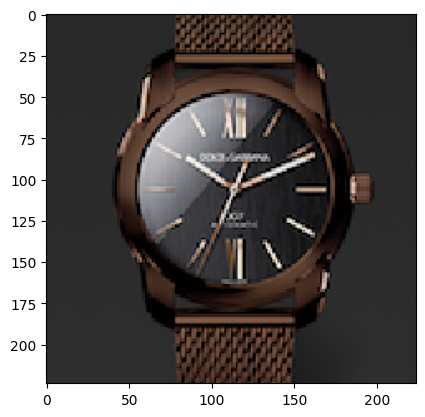

-----------------------------------------------------------------------
most similar products:


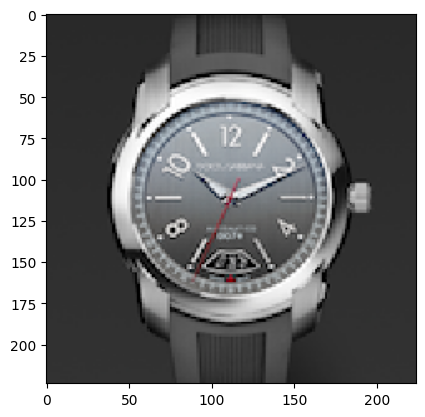

similarity score :  0.7531756


<ipython-input-30-bc886a56b404>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("similarity score : ",closest_imgs_scores[i])


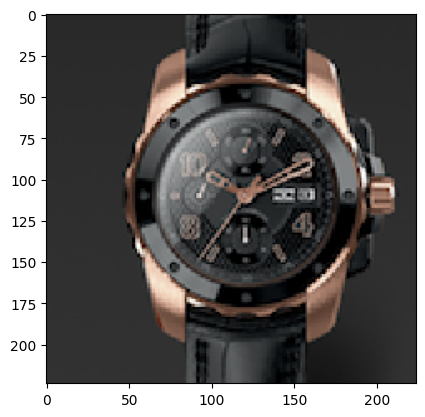

similarity score :  0.67414254


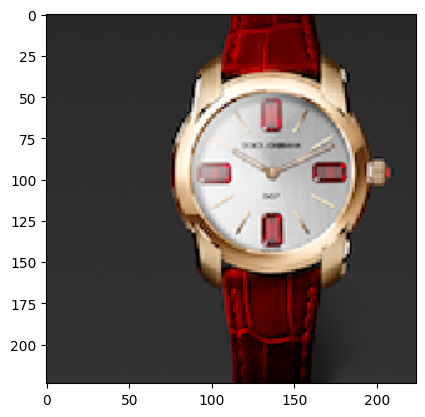

similarity score :  0.6273253


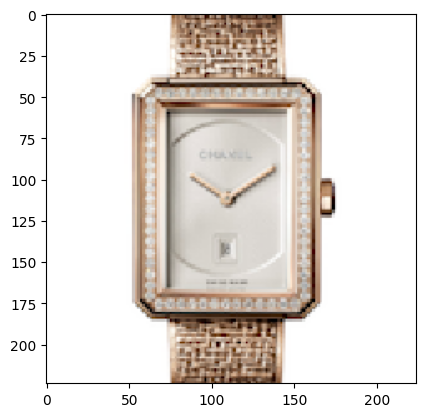

similarity score :  0.5643154


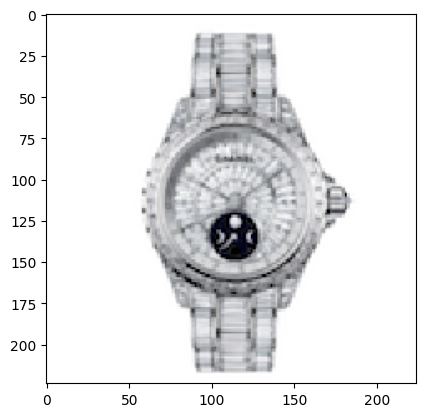

similarity score :  0.4378131


In [31]:
retrieve_most_similar_products(files[1])